In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.feature_selection import f_classif 
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", context="notebook")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

In [56]:
file_path = 'chagas_all_features_updated.xlsx'

df = pd.read_excel(file_path)
print(f"Dimensões: {df.shape}")

contagem = df['Obito_MS'].value_counts()
print("\nDistribuição do Target 'Obito_MS':")
print(contagem)
print(f"Proporção de Eventos: {(contagem[1]/len(df)*100):.2f}%")

Dimensões: (176, 278)

Distribuição do Target 'Obito_MS':
Obito_MS
0    108
1     68
Name: count, dtype: int64
Proporção de Eventos: 38.64%


## Features mais correlacionadas com Obito_MS

In [57]:
def calcular_importancia_obito_ms(df, target_col='Obito_MS'):
    print(f"\nAnalisando features para o alvo: {target_col} ...")
    
    ignore_cols = [
        'ID', 'Name', 'Filename', 'Date Holter', 'Time', 
        'Data_MSC', 'Tempo', 
        'Obito_MS_FU-5 years', 'Event (FU-5 years)', 
        target_col 
    ]
    
    features = [c for c in df.columns if c not in ignore_cols]
    
    res_num = []
    res_cat = []
    
    for col in features:
        #limpeza temporária de NaNs
        temp_df = df[[col, target_col]].dropna()
        
        if temp_df[col].nunique() <= 1: continue
        
        #numérico se tiver tipo numérico E >= 10 valores únicos
        #caso contrário, tratamos como Categórico/Binário
        is_numeric = pd.api.types.is_numeric_dtype(temp_df[col])
        n_unique = temp_df[col].nunique()
        
        if is_numeric and n_unique >= 10:
            #ANÁLISE NUMÉRICA
            
            #correlação Point-Biserial (Feature Contínua vs Target Binário)
            r, p_corr = pointbiserialr(temp_df[target_col], temp_df[col])
            
            #ANOVA F-Value (f_classif)
            #verifica se a média da feature é estatisticamente diferente entre Vivos e Óbitos
            X = temp_df[[col]]
            y = temp_df[target_col]
            f_score, p_anova = f_classif(X, y)
            
            res_num.append({
                'Feature': col, 
                'ANOVA_F_Score': f_score[0], #poder discriminatório
                'Correlation_r': r,          #direção (+/-)
                'Abs_Correlation': abs(r),   #magnitude
                'P_Value_ANOVA': p_anova[0]
            })
            
        else:
            #ANÁLISE CATEGÓRICA
            
            #tabela de contingência
            tab = pd.crosstab(temp_df[col], temp_df[target_col])
            #qui-quadrado
            chi2, p_chi2, _, _ = chi2_contingency(tab)
            
            #V de Cramer
            n = tab.sum().sum()
            min_dim = min(tab.shape) - 1
            v = np.sqrt(chi2 / (n * (min_dim if min_dim > 0 else 1)))
            
            res_cat.append({
                'Feature': col, 
                'Cramers_V': v, 
                'P_Value_Chi2': p_chi2
            })
            
    df_num = pd.DataFrame(res_num).sort_values('ANOVA_F_Score', ascending=False)
    df_cat = pd.DataFrame(res_cat).sort_values('Cramers_V', ascending=False)
    
    return df_num, df_cat

In [58]:
top_num, top_cat = calcular_importancia_obito_ms(df, target_col='Obito_MS')

print(f"\nTop 20 features numericas (ANOVA F-Score)")
display(top_num[['Feature', 'ANOVA_F_Score', 'Correlation_r', 'P_Value_ANOVA']].head(20))

print(f"\nTop 20 features categóricas (Cramer's V)")
display(top_cat[['Feature', 'Cramers_V', 'P_Value_Chi2']].head(20))


Analisando features para o alvo: Obito_MS ...

Top 20 features numericas (ANOVA F-Score)


,Feature,ANOVA_F_Score,Correlation_r,P_Value_ANOVA
1,Rassi Points,127.1856,0.6498,0.0000
2,FE,124.7590,-0.6462,0.0000
231,std_HRV_MFDFA_alpha2_Asymmetry,17.3473,-0.3011,0.0000
141,HRV_MFDFA_alpha2_Max,11.3590,-0.2476,0.0009
51,TpTe_75th,10.7801,0.2415,0.0012
220,std_HRV_MFDFA_alpha1_Max,9.2870,-0.2251,0.0027
221,std_HRV_MFDFA_alpha1_Delta,8.8763,-0.2203,0.0033
4,FC,8.7214,-0.2215,0.0036
61,Qtend/TendQ 98th,8.1990,0.2121,0.0047
19,QRS_dur_25th,7.8855,0.2082,0.0056



Top 20 features categóricas (Cramer's V)


,Feature,Cramers_V,P_Value_Chi2
18,TVMNS.1,0.8002,0.0000
19,AE diam.,0.7669,0.0000
3,Classe_FE,0.7437,0.0000
9,Ins Cardiaca,0.5887,0.0000
10,TSH,0.5748,0.1448
20,NYHA,0.5384,0.0000
1,Nat,0.3717,0.0828
4,HAS,0.3630,0.0000
2,Rassi Score,0.2765,0.0002
5,DM2,0.2106,0.0059


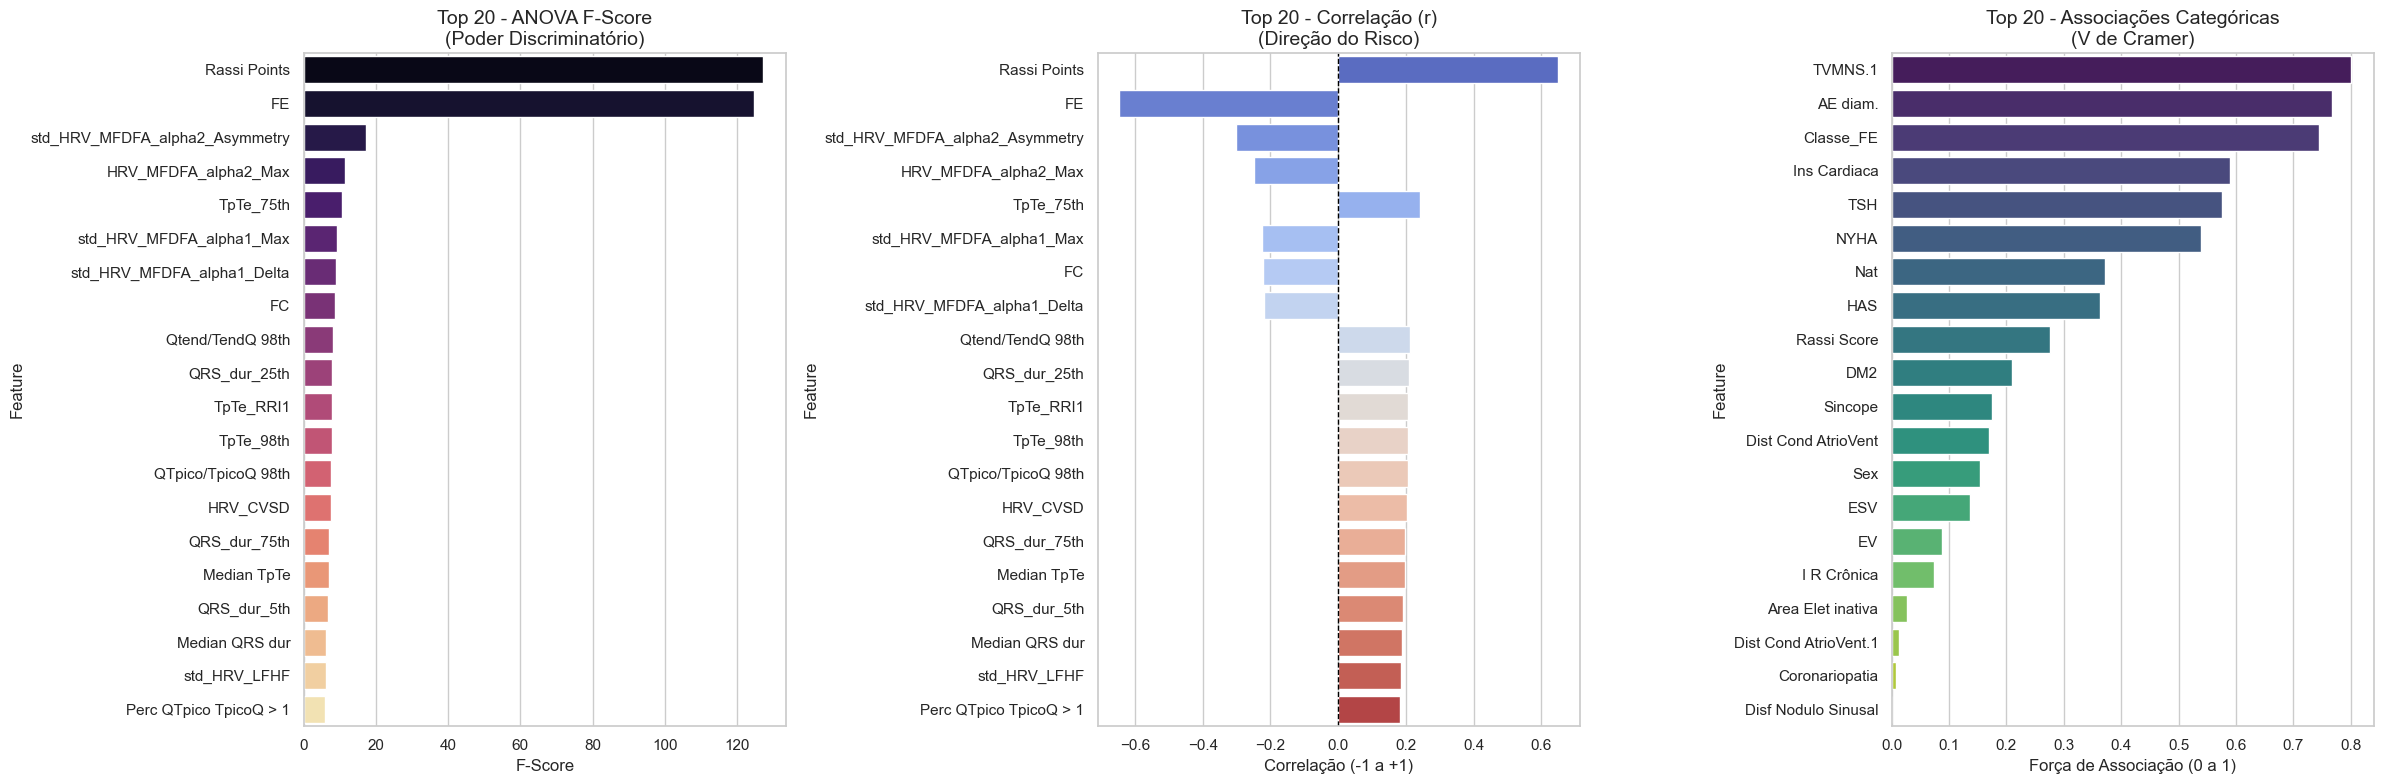

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

#ANOVA F-Score
sns.barplot(data=top_num.head(20), x='ANOVA_F_Score', y='Feature', ax=axes[0], palette='magma')
axes[0].set_title('Top 20 - ANOVA F-Score\n(Poder Discriminatório)', fontsize=14)
axes[0].set_xlabel('F-Score')

top_corr = top_num.sort_values('Abs_Correlation', ascending=False).head(20)
sns.barplot(data=top_corr, x='Correlation_r', y='Feature', ax=axes[1], palette='coolwarm')
axes[1].set_title('Top 20 - Correlação (r)\n(Direção do Risco)', fontsize=14)
axes[1].set_xlabel('Correlação (-1 a +1)')
axes[1].axvline(0, color='black', linewidth=1, linestyle='--')

#Categóricas
sns.barplot(data=top_cat.head(20), x='Cramers_V', y='Feature', ax=axes[2], palette='viridis')
axes[2].set_title("Top 20 - Associações Categóricas\n(V de Cramer)", fontsize=14)
axes[2].set_xlabel("Força de Associação (0 a 1)")

plt.tight_layout()
plt.show()

In [60]:
# top_num.to_csv('importancia_features_numericas_anova.csv', index=False)
# top_cat.to_csv('importancia_features_categoricas.csv', index=False)

## Features menos correlacionadas com Obito_MS


Analisando features MENOS correlacionadas para o alvo: Obito_MS ...

Top 20 features numericas MENOS correlacionadas (Menor ANOVA F-Score)


,Feature,ANOVA_F_Score,Correlation_r,P_Value_ANOVA
62,Median QTPico/TPicoQ,0.0000,0.0003,0.9965
105,HRV_CSI,0.0001,-0.0007,0.9924
135,HRV_MFDFA_alpha1_Fluctuation,0.0005,0.0017,0.9823
238,std_HRV_MSEn,0.0007,-0.0020,0.9792
92,HRV_VLF,0.0007,-0.0021,0.9782
40,TpicoQ_25th,0.0014,-0.0028,0.9702
13,QRS_amp_5th,0.0046,-0.0051,0.9462
186,std_HRV_LFn,0.0106,-0.0078,0.9182
14,QRS_amp_25th,0.0168,0.0098,0.8971
83,HRV_SDRMSSD,0.0179,0.0101,0.8937



Top 20 features categóricas MENOS associadas (Menor Cramer's V)


,Feature,Cramers_V,P_Value_Chi2
17,Fibri/Flutter Atrial,0.0000,1.0000
16,Disf Nodulo Sinusal,0.0000,1.0000
8,Coronariopatia,0.0085,0.9128
15,Dist Cond AtrioVent.1,0.0125,0.8698
14,Area Elet inativa,0.0275,0.7188
7,I R Crônica,0.0736,0.3356
13,EV,0.0884,0.2479
12,ESV,0.1365,0.0742
0,Sex,0.1539,0.0412
11,Dist Cond AtrioVent,0.1695,0.1782


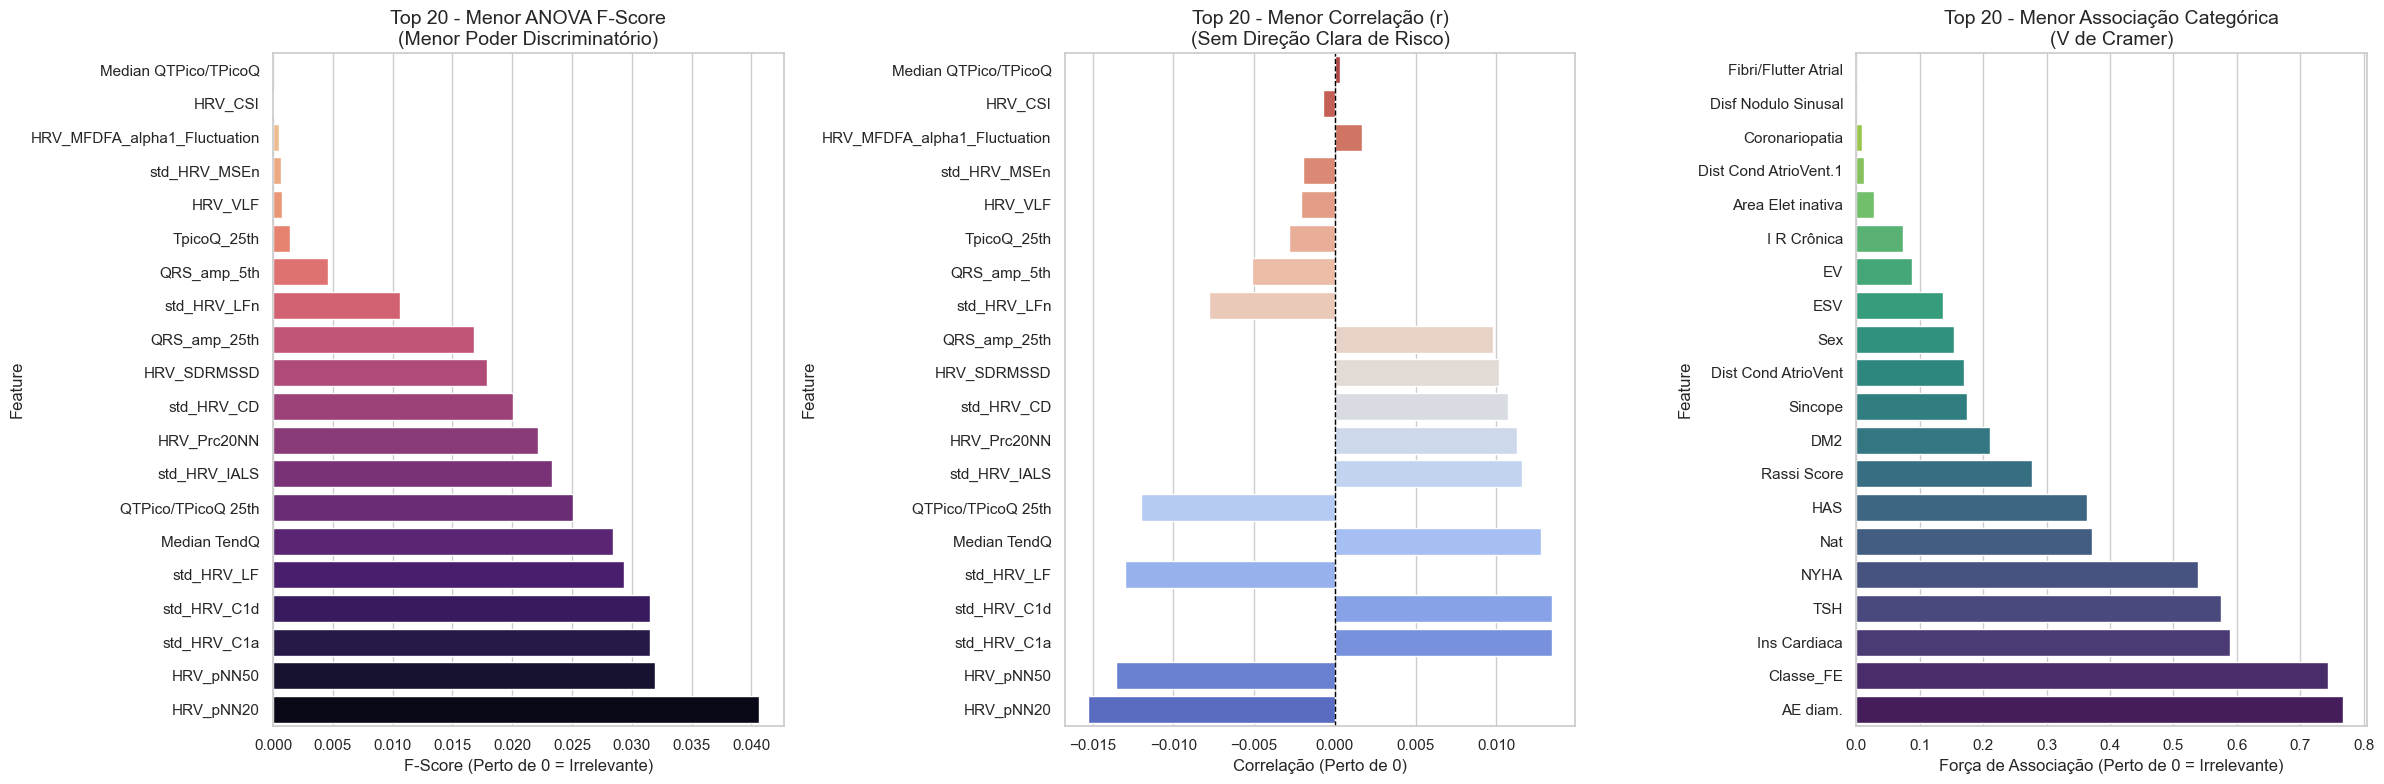

In [ ]:
def calcular_menos_importantes(df, target_col='Obito_MS'):
    print(f"\nAnalisando features MENOS correlacionadas para o alvo: {target_col} ...")
    
    ignore_cols = [
        'ID', 'Name', 'Filename', 'Date Holter', 'Time', 
        'Data_MSC', 'Tempo', 
        'Obito_MS_FU-5 years', 'Event (FU-5 years)', 
        target_col 
    ]
    
    features = [c for c in df.columns if c not in ignore_cols]
    
    res_num = []
    res_cat = []
    
    for col in features:
        temp_df = df[[col, target_col]].dropna()
        if temp_df[col].nunique() <= 1: continue
        
        is_numeric = pd.api.types.is_numeric_dtype(temp_df[col])
        n_unique = temp_df[col].nunique()
        
        if is_numeric and n_unique >= 10:
            # ANÁLISE NUMÉRICA
            r, p_corr = pointbiserialr(temp_df[target_col], temp_df[col])
            
            X = temp_df[[col]]
            y = temp_df[target_col]
            f_score, p_anova = f_classif(X, y)
            
            res_num.append({
                'Feature': col, 
                'ANOVA_F_Score': f_score[0],
                'Correlation_r': r,
                'Abs_Correlation': abs(r),
                'P_Value_ANOVA': p_anova[0]
            })
            
        else:
            # ANÁLISE CATEGÓRICA
            tab = pd.crosstab(temp_df[col], temp_df[target_col])
            chi2, p_chi2, _, _ = chi2_contingency(tab)
            n = tab.sum().sum()
            min_dim = min(tab.shape) - 1
            # Tratamento para evitar divisão por zero
            if min_dim > 0:
                v = np.sqrt(chi2 / (n * min_dim))
            else:
                v = 0
            
            res_cat.append({
                'Feature': col, 
                'Cramers_V': v, 
                'P_Value_Chi2': p_chi2
            })
            
    # ORDENAÇÃO ASCENDENTE (Do menor para o maior -> Menos Importantes Primeiro)
    df_num = pd.DataFrame(res_num).sort_values('ANOVA_F_Score', ascending=True)
    df_cat = pd.DataFrame(res_cat).sort_values('Cramers_V', ascending=True)
    
    return df_num, df_cat

# Executar
weak_num, weak_cat = calcular_menos_importantes(df, target_col='Obito_MS')

# Tabelas
print(f"\nTop 20 features numericas MENOS correlacionadas (Menor ANOVA F-Score)")
# P-Value ALTO indica irrelevância (queremos ver p-value > 0.05 aqui)
display(weak_num[['Feature', 'ANOVA_F_Score', 'Correlation_r', 'P_Value_ANOVA']].head(20))

print(f"\nTop 20 features categóricas MENOS associadas (Menor Cramer's V)")
display(weak_cat[['Feature', 'Cramers_V', 'P_Value_Chi2']].head(20))

# Gráficos
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# ANOVA F-Score (Baixo = Médias Iguais entre os grupos)
sns.barplot(data=weak_num.head(20), x='ANOVA_F_Score', y='Feature', ax=axes[0], palette='magma_r') 
axes[0].set_title('Top 20 - Menor ANOVA F-Score\n(Menor Poder Discriminatório)', fontsize=14)
axes[0].set_xlabel('F-Score (Perto de 0 = Irrelevante)')

# Correlação (Perto de 0 = Sem relação linear)
# Ordenamos pelo valor absoluto da correlação, do menor para o maior
weak_corr = weak_num.sort_values('Abs_Correlation', ascending=True).head(20)
sns.barplot(data=weak_corr, x='Correlation_r', y='Feature', ax=axes[1], palette='coolwarm_r')
axes[1].set_title('Top 20 - Menor Correlação (r)\n(Sem Direção Clara de Risco)', fontsize=14)
axes[1].set_xlabel('Correlação (Perto de 0)')
axes[1].axvline(0, color='black', linewidth=1, linestyle='--')

# Categóricas (V de Cramer baixo)
sns.barplot(data=weak_cat.head(20), x='Cramers_V', y='Feature', ax=axes[2], palette='viridis_r')
axes[2].set_title("Top 20 - Menor Associação Categórica\n(V de Cramer)", fontsize=14)
axes[2].set_xlabel("Força de Associação (Perto de 0 = Irrelevante)")

plt.tight_layout()
plt.show()